Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

Load Dataset

In [2]:
data = pd.read_csv("Churn_Modelling.csv") 
display(data.head())
print(data.info())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None


Preprocessing

In [3]:
data = data.drop(["RowNumber", "CustomerId", "Surname"], axis=1)
for col in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
X = data.drop("Exited", axis=1) 
y = data["Exited"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

Train Models

In [5]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, random_state=42)
}
results = {}
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    print(f"\n{name} Report:")
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))
    results[name] = (y_pred, y_prob, model)


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      2389
           1       0.41      0.64      0.50       611

    accuracy                           0.74      3000
   macro avg       0.65      0.70      0.66      3000
weighted avg       0.79      0.74      0.76      3000

Accuracy: 0.738
ROC-AUC: 0.7616119708511255

Random Forest Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      2389
           1       0.54      0.63      0.58       611

    accuracy                           0.82      3000
   macro avg       0.72      0.75      0.73      3000
weighted avg       0.83      0.82      0.82      3000

Accuracy: 0.8166666666666667
ROC-AUC: 0.8452485101176355

Gradient Boosting Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.88      2389
           1       0.53      0.69      0.60       611

  

Confusion Matrix Visualization

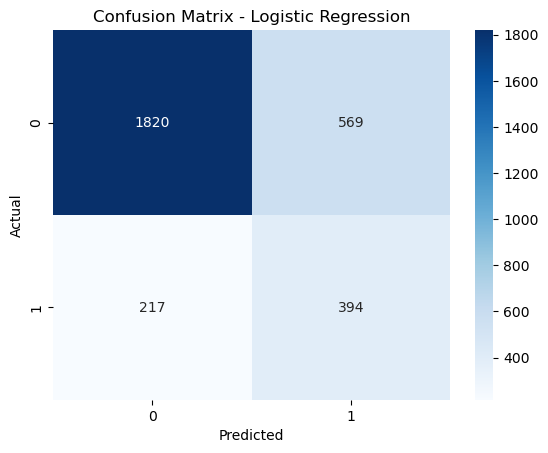

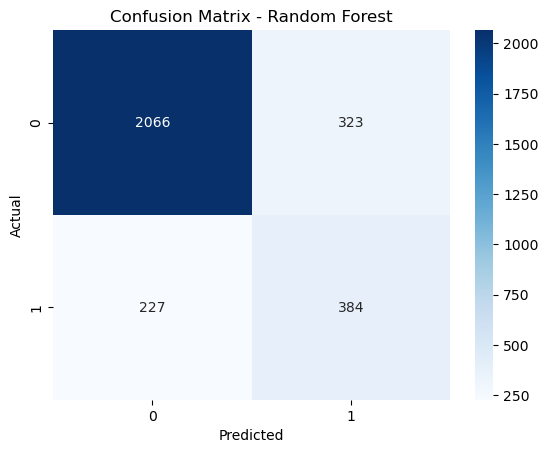

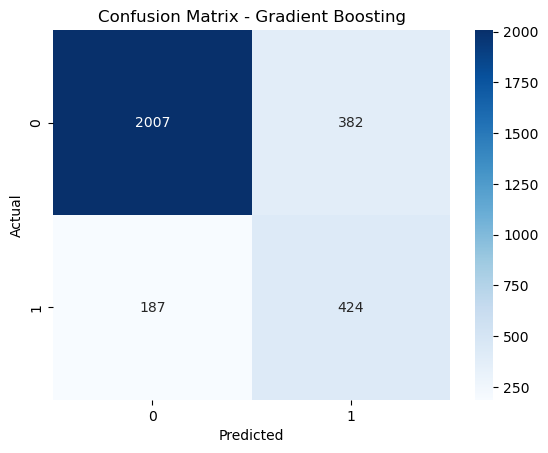

In [6]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
for name, (y_pred, _, _) in results.items():
    plot_confusion_matrix(y_test, y_pred, name)

ROC Curve

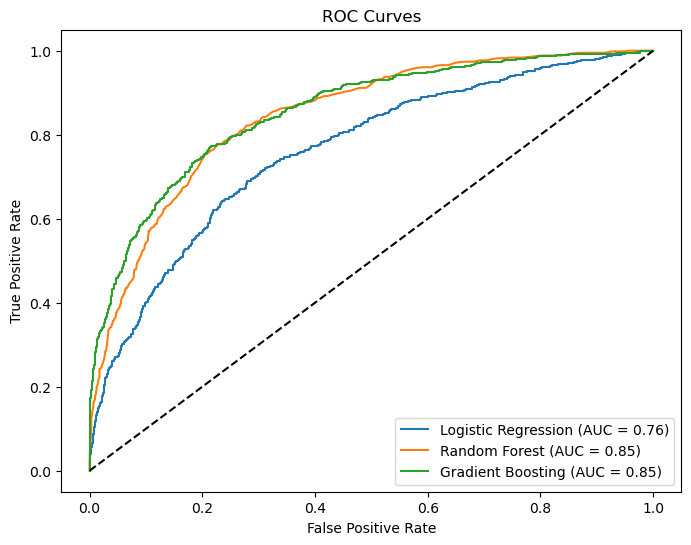

In [7]:
plt.figure(figsize=(8,6))
for name, (y_pred, y_prob, _) in results.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

Feature Importance (Random Forest Example)

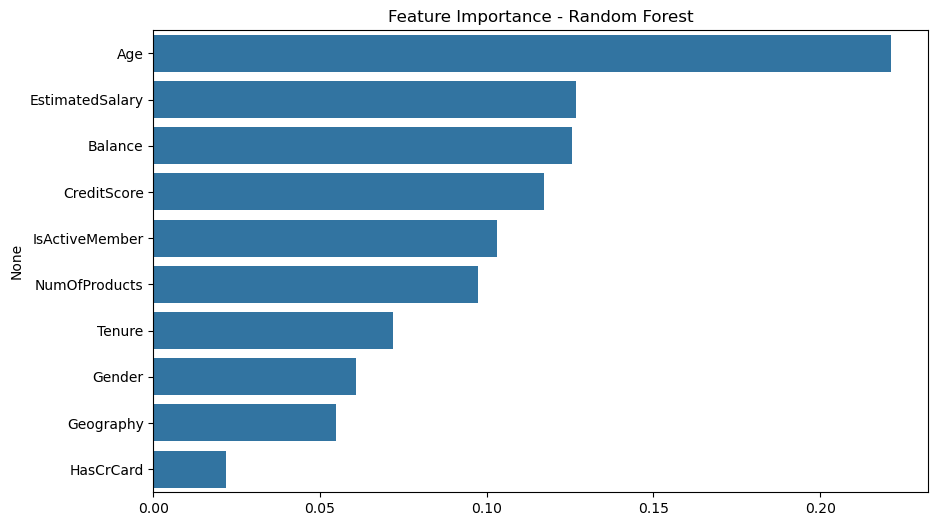

In [8]:
rf_model = results["Random Forest"][2]
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title("Feature Importance - Random Forest")
plt.show()

In [11]:
# Predict churn for a single customer

sample_customer = pd.DataFrame([{
    'CreditScore': 600,
    'Geography': 'France',
    'Gender': 'Female',
    'Age': 45,
    'Tenure': 2,
    'Balance': 50000,
    'NumOfProducts': 1,
    'HasCrCard': 1,
    'IsActiveMember': 0,
    'EstimatedSalary': 60000
}])

# Encode categorical features (must match training preprocessing)
sample_customer['Geography'] = LabelEncoder().fit_transform(sample_customer['Geography'])
sample_customer['Gender'] = LabelEncoder().fit_transform(sample_customer['Gender'])

# Scale numerical features
sample_customer_scaled = scaler.transform(sample_customer)

# Use your best model (e.g., Gradient Boosting)
gb_model=results["Gradient Boosting"][2]
prediction = gb_model.predict(sample_customer_scaled) 
probability = gb_model.predict_proba(sample_customer_scaled) 
print("Predicted Churn:", "Yes" if prediction[0] == 1 else "No") 
print("Churn Probability:", round(probability[0][1], 2))


Predicted Churn: Yes
Churn Probability: 0.92
